# MOOC User Action Dataset Pipeline: FIGRL test

The dataset used in this experiment can be downloaded through te following link:
http://snap.stanford.edu/data/act-mooc.html

Before the pipeline for the Stanford Wikipedia dataset kicks off, some global parameters need to be defined. We devised a manual
`kfold`-fold out-of-time validation, by dividing the dataset based on a rolling window approach. `timeframe`specifes which timeframe is selected. The `embedding_size`defines the dimension of the embeddings learned by Fast Inductive Graph Representation Learning algorithm. The `intermediate_dimension` is given by choosing an appropriate approximation ratio by the following formula: `intermediate_dimension` = max{4log(amount of nodes)/e^2, k/e^2} with e the approximation ratio and k the final embeddings_size.

In [1]:
# Global parameters:
embedding_size = 40
intermediate_dimension = 400

## 1. Loading the MOOC Dataset

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd 
import numpy as np
import time
import dateparser
import networkx as nx
import stellargraph as sg
import scipy
from scipy.sparse import csr
import scipy.sparse

The action file has following attributes:

ACTIONID: a unique id for each action.

USERID: a unique id for each user.

TARGETID: a unique id for each target activity.

TIMESTAMP: timestamp for the action in seconds from the beginning.

In [3]:
df_action = pd.read_csv("C:\\Users\\hendr\\OneDrive\\Documents\\KU Leuven Job\\datasets\\mooc_actions.tsv", sep='\t')

df_action = df_action.set_index('ACTIONID')
pd.Series(df_action.index).is_unique

True

The feature file has following attributes:

ACTIONID: a unique id for each action.

FEATUREx: a feature value associated with the action. Total four in count, making it a 4-dimensional feature vector

In [4]:
df_feature = pd.read_csv("C:\\Users\\hendr\\OneDrive\\Documents\\KU Leuven Job\\datasets\\mooc_action_features.tsv", sep='\t')

df_feature = df_feature.set_index('ACTIONID')
pd.Series(df_feature.index).is_unique

True

The lable file has following attributes:
    
ACTIONID: a unique id for each action.
    
LABEL: a binary label indicating whether the student drops-out after the action. The value is 1 for drop-out actions, 0 otherwise.

In [31]:
df_labels = pd.read_csv("C:\\Users\\hendr\\OneDrive\\Documents\\KU Leuven Job\\datasets\\mooc_action_labels.tsv", sep='\t')
df_labels = df_labels.drop(columns='ACTIONID')
df_labels.index.name = 'ACTIONID'

pd.Series(df_labels.index).is_unique

True

In [32]:
df = pd.merge(df_action, df_feature.loc[df_action.index], left_index=True, right_index=True)
df = pd.merge(df, df_labels.loc[df.index], left_index=True, right_index=True)
pd.Series(df.index).is_unique

True

In [33]:
df['USERID']+=max(df.index)+1
df['TARGETID']+=max(df.USERID)+1
print(min(df.TARGETID))

418796


In [34]:
cutoff = round(0.6*len(df))
train_data = df.head(cutoff)
inductive_data = df.tail(len(df)-cutoff)

In [35]:
print('The distribution of banned pages for the train data is:\n', train_data['LABEL'].value_counts())
print('The distribution of banned pages for the inductive data is:\n', inductive_data['LABEL'].value_counts())

The distribution of banned pages for the train data is:
 0    244461
1      2588
Name: LABEL, dtype: int64
The distribution of banned pages for the inductive data is:
 0    163222
1      1478
Name: LABEL, dtype: int64


### 1.1 Undersampling

In [36]:
undersampling_rate = None

In [37]:
from imblearn.under_sampling import RandomUnderSampler

if not undersampling_rate is None:
    print("An undersampling rate of ", undersampling_rate, "is applied.")
    train_data['index'] = train_data.index
    undersample = RandomUnderSampler(sampling_strategy=(undersampling_rate))
    X, y = undersample.fit_resample(train_data, train_data['state_label'])
    train_data = X.set_index(X['index']).drop('index',axis=1)
    print('The new distribution for the train set is:\n', train_data["state_label"].value_counts())

## 2. Construct the Graph Network

A networkx graph is constructed with edit, user and webpage nodes. Creating a three partite graph. The FI-GRL framework derives embeddings starting from an adjacency matrix that it constructs using the graph's edgelist. 

In [38]:
nodes = {"action":train_data.index, "USERID":train_data.USERID, "TARGETID":train_data.TARGETID}
edges = [zip(train_data.USERID, train_data.index),zip(train_data.TARGETID, train_data.index)]
g_nx = nx.Graph()
for key, values in nodes.items():
            g_nx.add_nodes_from(values, ntype=key)
for edge in edges:
            g_nx.add_edges_from(edge)

pd.options.mode.chained_assignment = None


## 3. Train FIGRL

We want to keep the original indices after concatenating the train and inductive data, because they represent the transaction node ids. We need to concatenate these dataframes in order to easily construct the new graph.

In [39]:
inductive_graph_data = pd.concat((train_data,inductive_data))
pd.Series(inductive_graph_data.index).is_unique

True

FI-GRL, a fast inductive graph representation framework is trained using the aforeconstructed graph. This algorithm is implemented in matlab so we make use of matlab.engine to deploy its native implementation. First, we instantiate the FI-GRL class with the intermediate dimension of the matrix between the input graph and the embedding space, in addition to the size of final dimension (embedding space). FI-GRL's train step returns three matrices: U, which represents the embedding space, sigma and v, which are matrices that will be used in the inductive step to generate embeddings for unseen nodes. 

In [40]:
A = nx.adjacency_matrix(g_nx)
print(A.shape)

(253389, 253389)


In [41]:
t0 = time.time()
n,m = A.shape
diags = A.sum(axis=1).flatten()
D = scipy.sparse.spdiags(diags, [0], n, n, format='csr')
#L = D - A
with scipy.errstate(divide='ignore'):
   diags_sqrt = 1.0/np.lib.scimath.sqrt(diags)
diags_sqrt[np.isinf(diags_sqrt)] = 0
DH = scipy.sparse.spdiags(diags_sqrt, [0], n, n, format='csr')

Normalized_random_walk = DH.dot(A.dot(DH))

S = np.random.randn(n, intermediate_dimension) / np.sqrt(intermediate_dimension)

#S = np.array(pd.read_csv('S_train_matrix.csv', header=None))

C = Normalized_random_walk.dot(S)

np.savetxt("S_train_matrix.csv", S, delimiter=",")

from scipy import sparse
sC = sparse.csr_matrix(C)

U, sigma, V = scipy.sparse.linalg.svds(sC, k=embedding_size, tol=0,which='LM')
V = V.transpose()
sigma = np.diag(sigma)

t1 = time.time()
print(t1-t0)

223.55764985084534


#### Save embeddings

In [42]:
figrl_train_emb = pd.DataFrame(U)
figrl_train_emb = figrl_train_emb.set_index(figrl_train_emb.index)
figrl_train_emb = figrl_train_emb.loc[train_data.index]
sigma = np.array(sigma)
V = np.array(V)
S = np.array(S)

## 4. Inductive Step

In [43]:
nodes = {"action":inductive_graph_data.index, "USERID":inductive_graph_data.USERID, "TARGETID":inductive_graph_data.TARGETID}
edges = [zip(inductive_graph_data.USERID, inductive_graph_data.index),zip(inductive_graph_data.TARGETID, inductive_graph_data.index)]
graph_full = nx.Graph()

for key, values in nodes.items():
            graph_full.add_nodes_from(values, ntype=key)
for edge in edges:
            graph_full.add_edges_from(edge)

#### New inductive S

In [44]:
S = np.random.randn(max(inductive_graph_data.TARGETID)+1, intermediate_dimension) / np.sqrt(intermediate_dimension)

In [45]:
import collections

inductive_dict = {}
for node in inductive_data.index:
    user = inductive_data.loc[node].USERID
    item = inductive_data.loc[node].TARGETID
    inductive_dict[node] = [user,item]
inductive_dict = collections.OrderedDict(sorted(inductive_dict.items()))

In [46]:
degrees = nx.degree(graph_full)
train_degrees = dict(degrees)
train_degrees = collections.OrderedDict(sorted(train_degrees.items()))

In [47]:
from scipy.sparse import coo_matrix
def get_vector(inductive_dict, max_id):
    print("creating sparse vector matrix")
    row  = []
    col  = []
    data = []
    i = 0
    for node, v in inductive_dict.items():
        for n in v:
            if n is not None:
                row.append(i)
                col.append(n)
                #calculate value
                inductive_degree = len([x for x in v if x != None])
                value = 1/np.sqrt(inductive_degree)
                value = value * (1/np.sqrt(train_degrees[n]))
                data.append(value)
        i+=1
    row = np.array(row)
    col = np.array(col)
    data = np.array(data)
    return coo_matrix((data, (row, col)), shape=(len(inductive_dict), max_id+1))

In [48]:
t0 = time.time()
v = get_vector(inductive_dict, max(inductive_graph_data.TARGETID))
t1 = time.time()
print(t1-t0)

creating sparse vector matrix
1.6300294399261475


In [49]:
import scipy.sparse

t0 = time.time()
inductive_degrees = []

#altijd 2 (onderstaand)
for l in inductive_dict.values():
    x = 0
    for i in l:
        if i is not None:
            x+=1
    inductive_degrees.append(x)
    
def sqrt_d_inv(inductive_degrees):
        sqrt_d_inv = np.array([1/np.sqrt(degree)  if degree > 0 else 0 for degree in inductive_degrees])
        return scipy.sparse.spdiags(sqrt_d_inv,0, sqrt_d_inv.size, sqrt_d_inv.size)
sqrt_d_inv = sqrt_d_inv(inductive_degrees)
t1 = time.time()
print(t1-t0)

0.3751070499420166


In [51]:
t0 = time.time()
p = v.dot(S)
U =(p.dot(V)).dot(np.linalg.inv(sigma))
U = sqrt_d_inv.dot(U)
t1 = time.time()

print(t1-t0)

3.5816490650177


In [52]:
figrl_inductive_emb = pd.DataFrame(U, index=inductive_data.index)

## 5. Evaluation

In [53]:
from xgboost import XGBClassifier
classifier = XGBClassifier(n_estimators=100)

In [54]:
train_labels = train_data['LABEL']
figrl_train_emb = pd.merge(figrl_train_emb, train_data.loc[figrl_train_emb.index].drop('LABEL', axis=1), left_index=True, right_index=True)
figrl_inductive_emb = pd.merge(figrl_inductive_emb, inductive_data.loc[figrl_inductive_emb.index].drop('LABEL', axis=1), left_index=True, right_index=True)

baseline_train = train_data.drop('LABEL', axis=1)
baseline_inductive = inductive_data.drop('LABEL', axis=1)

classifier.fit(baseline_train, train_labels)
baseline_predictions = classifier.predict_proba(baseline_inductive)
    
classifier.fit(figrl_train_emb, train_labels)
predictions = classifier.predict_proba(figrl_inductive_emb)


In [55]:
import scikitplot
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from matplotlib import pyplot

def pr_curve(probabilities, labels, name):

        """
        This function plots the precision recall curve for the used classification model and a majority classifier.
        
        """
        probs = probabilities[:, 1]
        precision, recall, _ = precision_recall_curve(labels, probs)
        pyplot.plot(recall, precision, label=name)
        # axis labels
        pyplot.xlabel('Recall')
        pyplot.ylabel('Precision')
        # show the legend
        pyplot.legend()
        
        print('Average precision-recall score for ', name, ' configuration XGBoost: {0:0.10f}'.format(average_precision_score(labels, probs)))

Average precision-recall score for  FI-GRL  configuration XGBoost: 0.0835907682
Average precision-recall score for  Baseline  configuration XGBoost: 0.0292943903


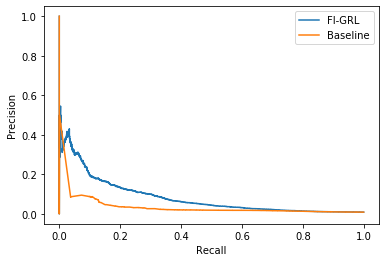

In [56]:
inductive_labels = df.loc[figrl_inductive_emb.index]['LABEL']

pr_curve(predictions, inductive_labels, "FI-GRL")

pr_curve(baseline_predictions, inductive_labels, "Baseline")